In [23]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [24]:
class CustomDataset(Dataset):
    def __init__(self, json_dirs, image_dirs, transform=None):
        self.json_dirs = json_dirs
        self.image_dirs = image_dirs
        self.transform = transform
        self.samples = []

        for json_dir, image_dir in zip(json_dirs, image_dirs):
            # Iterar sobre cada arquivo de imagem no diretório
            for filename in os.listdir(image_dir):
                if filename.endswith('.png'):
                    img_path = os.path.join(image_dir, filename)
                    # Verificar se existe um arquivo JSON correspondente
                    json_filename = filename.replace('.png', '.json')
                    json_path = os.path.join(json_dir, json_filename)
                    if os.path.exists(json_path):
                        with open(json_path, 'r') as f:
                            data = json.load(f)
                            labels = data.get('labels', [])
                            if labels:
                                label = float(labels[0]['class'])  
                                self.samples.append((img_path, label))
                            else:
                                print(f"Rótulo ausente para: {img_path}")
                    else:
                        print(f"Arquivo JSON correspondente não encontrado para: {img_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
json_dirs = [r'C:\Users\bruna\OneDrive - Universidade do Minho\images\0', 
             r'C:\Users\bruna\OneDrive - Universidade do Minho\images\2']
image_dirs = [r'C:\Users\bruna\OneDrive - Universidade do Minho\images\0\class_0',
              r'C:\Users\bruna\OneDrive - Universidade do Minho\images\2\class_2']

In [25]:
import pathlib
import numpy as np
data_dir = pathlib.Path("C:/Users/bruna/OneDrive - Universidade do Minho/images")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])).tolist() # created a list of class_names from the subdirector
class_names

['0', '1', '2', '3', '4', '6']

Image shape: (254, 254, 4)


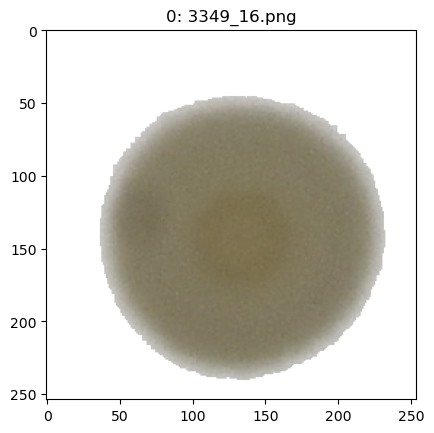

In [235]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

target_class = random.choice(class_names)
target_folder: str = "C:/Users/bruna/OneDrive - Universidade do Minho/images/0/class_0/" 


random_image = random.sample(os.listdir(target_folder), 1)


img = mpimg.imread(target_folder + "/" + random_image[0])
plt.imshow(img)
plt.title(f"{target_class}: {random_image[0]}")

print(f"Image shape: {img.shape}")

In [29]:
# Definir transformações para pré-processamento das imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [30]:
dataset = CustomDataset(json_dirs, image_dirs, transform=transform)

In [31]:
# Filtrar amostras ausentes
filtered_samples = [(img, label) for img, label in dataset.samples if label is not None]

In [32]:
# Verificar se há amostras restantes
if len(filtered_samples) > 0:
    # Criar DataLoader apenas com amostras não ausentes
    train_loader = DataLoader(filtered_samples, batch_size=32, shuffle=True)
else:
    print("Não há amostras no conjunto de dados. Verifique se os arquivos JSON foram carregados corretamente.")

In [33]:
#Definir número de folds para a validação cruzada
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [34]:
#armazenar os resultados de cada fold
fold_accuracies = []

In [35]:
for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(dataset)), [label for _, label in dataset.samples])):
    print(f'Fold {fold+1}/{num_folds}:')

    #Dividir em treinamento e validação
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    #DataLoader para conjuntos de treinamento e validação
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

Fold 1/5:
Fold 2/5:
Fold 3/5:
Fold 4/5:
Fold 5/5:


In [36]:
#ResNet pré-treinada

import torchvision.models as models

resnet = models.resnet50(pretrained=True)

C:\Users\bruna\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bruna\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# Congelar os parâmetros da ResNet para que não sejam atualizados durante o treinamento
for param in resnet.parameters():
    param.requires_grad = False

In [38]:
# Obter o número de features na última camada da ResNet
num_features = resnet.fc.in_features

In [39]:
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [40]:
# Obter o número de features na última camada linear da ResNet
num_features = resnet.fc[0].in_features

In [41]:
# Substituir a última camada fully connected para se adequar ao nosso problema
resnet.fc = nn.Linear(num_features, 1)  # Neste caso, temos uma única classe (0 ou 1)

In [42]:
# Definir a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss()  # Usamos BCEWithLogitsLoss porque estamos tratando um problema de classificação binária
optimizer = optim.Adam(resnet.parameters(), lr=0.001, weight_decay=1e-5) 


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    resnet.train()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)  

        optimizer.zero_grad()

        outputs = resnet(inputs)

        
        predictions = (outputs.squeeze(1) > 0.5).float()

        # Calcula o número de previsões corretas
        correct_predictions += (predictions == labels).sum().item()

        # Atualiza o total de exemplos
        total_samples += labels.size(0)

        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Avaliar o modelo na parte de validação
resnet.eval()  #modo de avaliação
correct_predictions = 0
total_samples = 0

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.float().to(device)

    outputs = resnet(inputs)

    predictions = (outputs.squeeze(1) > 0.5).float()

    correct_predictions += (predictions == labels).sum().item()
    total_samples += labels.size(0)

fold_accuracy = correct_predictions / total_samples
print(f'Accuracy on validation set: {fold_accuracy:.4f}')
fold_accuracies.append(fold_accuracy)

Epoch [1/10], Loss: -62.3392, Accuracy: 0.0002
Epoch [2/10], Loss: -192.1416, Accuracy: 0.0000
Epoch [3/10], Loss: -322.9689, Accuracy: 0.0000


In [ ]:
# Calcular a média das acurácias dos folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f'Mean accuracy across folds: {mean_accuracy:.4f}')